In [1]:
import bqplot
import datetime
import time
import ee
from IPython.display import display, IFrame, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_functions import *
from skimage.viewer import ImageViewer
from skimage.io import imread
from imageio import imwrite
from gee_library import *
# Configure the pretty printing output.
import pprint
from tqdm import tqdm
from tqdm import tnrange
import numba as nb
from fancyimpute import KNN, SoftImpute
from sklearn.preprocessing import normalize, StandardScaler
import pylab
from scipy.stats import normaltest, shapiro, anderson, skew
import seaborn as sns
import random

pp = pprint.PrettyPrinter(depth=4)
tqdm.monitor_interval = 0

# Authenticate to the Earth Engine servers.
ee.Initialize()


SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

D:\Programs\Anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
Using TensorFlow backend.


In [2]:
# Importing and separating just for grains
corn_yield = pd.read_csv('data/Corn_2007-2016_ALLSTATES.csv')
corn_grain = corn_yield[(corn_yield['YIELD in BU / ACRE'] != ' ') & \
                        (corn_yield['COMMODITY'] == 'CORN, GRAIN')][['YEAR', 'LOCATION', 'STATE ANSI', 'COUNTY ANSI', 'YIELD in BU / ACRE', 'AREA HARVESTED in ACRES']] \
             .rename(columns={'STATE ANSI':'STATE_FIPS', 'COUNTY ANSI':'COUNTY_FIPS', 'YIELD in BU / ACRE':'YIELD', 'AREA HARVESTED in ACRES':'AREA'})
corn_silage = corn_yield[(corn_yield['YIELD in TONS / ACRE'] != ' ') & (corn_yield['COMMODITY'] == 'CORN, SILAGE')]

# Drop those that combined counties/ and no areas of planting and make sure it's int
corn_grain = corn_grain[corn_grain['COUNTY_FIPS'] != '   ']
corn_grain = corn_grain[corn_grain['AREA'] != ' '].reset_index().drop(['index'], axis=1)
corn_grain['COUNTY_FIPS'] = corn_grain['COUNTY_FIPS'].map(int)
corn_grain['AREA'] = corn_grain['AREA'].apply(lambda a: int(a.replace(',', '')))
corn_grain['YIELD'] = corn_grain['YIELD'].map(float)

unique_data = sorted([list(x) for x in set(tuple(x) for x in corn_grain[['STATE_FIPS', 'COUNTY_FIPS']].values)])

print('There are a total of {} states with {} counties in the dataset.'.format(len(corn_grain['STATE_FIPS'].unique()), len(unique_data)))
# Print
display(corn_grain.head())
corn_grain.to_csv('data/corn_grain.csv')

There are a total of 41 states with 2106 counties in the dataset.


,YEAR,LOCATION,STATE_FIPS,COUNTY_FIPS,YIELD,AREA
0,2016,"ALABAMA, BLACK BELT, DALLAS",1,47,118.8,5000
1,2016,"ALABAMA, BLACK BELT, ELMORE",1,51,151.8,3300
2,2016,"ALABAMA, BLACK BELT, MACON",1,87,131.9,1350
3,2016,"ALABAMA, BLACK BELT, MARENGO",1,91,137.2,7800
4,2016,"ALABAMA, BLACK BELT, PERRY",1,105,123.7,5900


In [4]:
test1 = imread('data/MODIS_LAND/MODIS_LAND_38_67.tif')

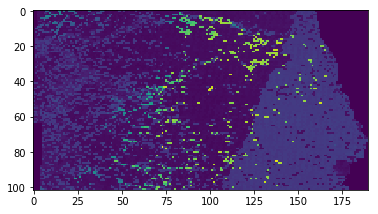

In [5]:
plt.imshow(test1[:, :, 6])
plt.show()

In [3]:
def merge_img_array(arr_1, nband_1, arr_2, nband_2):
    """
    Merge images from difference arrays of 2D images. (ex. one has 7, the other has 2, both of them has 500 temporal images, then 
    we merge to a list of 500 temporal images with 9 bands.) The variable arr_1 is the main one.
    """
    m = arr_1.shape[0]
    n = arr_1.shape[1]
    l1 = arr_1.shape[2]
    l2 = arr_2.shape[2]
    merged_arr = np.empty((m, n, l1+l2))
    
    
    for i in range(int(l1/nband_1)):
        position_1 = i*nband_1 + i*nband_2
        position_2 = position_1 + nband_1
        merged_arr[:, :, position_1 : position_1+nband_1] = arr_1[:, :, i*nband_1 : i*nband_1+nband_1]
        merged_arr[:, :, position_2 : position_2+nband_2] = arr_2[:, :, i*nband_2 : i*nband_2+nband_2]
        
    # Check before done
    clause_1 = np.all(np.equal(merged_arr[:, :, 0:nband_1], arr_1[:, :, 0:nband_1]))
    clause_2 = np.all(np.equal(merged_arr[:, :, -nband_2:], arr_2[:, :, -nband_2:]))
    if (clause_1 == True) and (clause_2 == True):
        #print('done')
        pass
    else:
        raise ValueError('A very specific bad thing happened. Maybe the number of given band is wrong?')
    return merged_arr

In [4]:
# Getting county level information and statistics
# Note that the function is designed for more than one pic --> becareful with USDA which only give 1 pic per year

target_sat = {'USDA/NASS/CDL':['cropland'], \
              'MODIS/006/MYD11A2':[0,4], \
              'MODIS/006/MOD09A1':[0,1,2,3,4,5,6] \
        }  
folders = ['USDA_CROP', \
           'MODIS_TEMP', \
           'MODIS_LAND'
           ]
locations = [(loc[0], loc[1]) for loc in unique_data]
dates = ['2007-1-2', '2017-1-2']
scale  = 500   # 500m = 1 pixel
dates_of_images = {folder:[] for folder in folders}

#################################################################################################

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')

for folder, target in zip(folders, target_sat):

    if folder == 'USDA_CROP':
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) 
    else:
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    if folder == 'USDA_CROP':
        img = ee.Image(img).eq(1)  # only corn 
    else:
        img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + target +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per county. (", v['percent_available'], "%)")
        
"""
    # Getting images
    for i, (loc1, loc2) in enumerate(locations):

        im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
        scale  = scale
        crs = 'EPSG:4326'   # Coordinate Reference System

        # filter for a county
        region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
        region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
        region = ee.Feature(region.first()) # get the coordinates and other features

        while True:
            try:
                export_image(img.clip(region), folder, im_name, scale, crs)
            except Exception:
                print(Exception)
                time.sleep(10)
                continue
            break
        if (i%250 == 0) or (i == len(locations)-1):
            print(i)
"""


 ######################### USDA/NASS/CDL #########################
Total Dates Available:  10
Dates available:  ['2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31']
Band cropland will be downloaded in 10 images per county. ( 100.0 %)

 ######################### MODIS/006/MYD11A2 #########################
Total Dates Available:  380
Dates available:  ['2007-03-05', '2007-03-13', '2007-03-21', '2007-03-29', '2007-04-06', '2007-04-14', '2007-04-22', '2007-04-30', '2007-05-08', '2007-05-16', '2007-05-24', '2007-06-01', '2007-06-09', '2007-06-17', '2007-06-25', '2007-07-03', '2007-07-11', '2007-07-19', '2007-07-27', '2007-08-04', '2007-08-12', '2007-08-20', '2007-08-28', '2007-09-05', '2007-09-13', '2007-09-21', '2007-09-29', '2007-10-07', '2007-10-15', '2007-10-23', '2007-10-31', '2007-11-08', '2007-11-16', '2007-11-24', '2007-12-02', '2007-12-10', '2007-12-18', '2007-12-26', '2008-03-04', '2008-03-12'

In [5]:
# For moisture content because the collection time is not the same as MODIS, we created a time interval (+-4 days) of the MODIS image and take median out of that
# to be incorporated with MODIS.

# creating time intervals
backward = datetime.timedelta(days=-4)
date_list = [datetime.date(int(date.split('-')[0]), int(date.split('-')[1]), int(date.split('-')[2])) + backward for date in dates_of_images['MODIS_LAND']] 
date_list += [date_list[-1] - backward]

# changing to list and string format
date_list = ['{}-{}-{}'.format(date.year, date.month, date.day) for date in date_list]
date_list = [[date_list[i], date_list[i+1]] for i in range(len(date_list)-1)]

folder = 'USDA_MOISTURE'
#dates_of_images[folder] = date_list
locations = [(loc[0], loc[1]) for loc in unique_data]
scale  = 500   # 500m = 1 pixel

#################################################################################################

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')
print('Total Dates {}'.format(len(date_list)))
for i, dates in enumerate(date_list):
    
    if i == 0:
        img = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                        .filterDate(dates[0], dates[1]) \
                        .select([0, 1]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))\
                        .median()
    else:
        img2 = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                    .filterDate(dates[0], dates[1]) \
                    .select([0, 1]) \
                    .filter(ee.Filter.calendarRange(3,12,'month'))\
                    .median()
        img = img.addBands(img2)
        
print('There are {} total number of images'.format(len(img.bandNames().getInfo())))
"""
# Getting images
for i, (loc1, loc2) in enumerate(locations):

    im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
    scale  = scale
    crs = 'EPSG:4326'   # Coordinate Reference System

    # filter for a county
    region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
    region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
    region = ee.Feature(region.first()) # get the coordinates and other features

    while True:
        try:
            export_image(img.clip(region), folder, im_name, scale, crs)
        except Exception:
            print(Exception)
            time.sleep(10)
            continue
        break
    if (i%500 == 0) or (i == len(locations)-1):
        print(i)
"""

Total Dates 380
There are 532 total number of images


"\n# Getting images\nfor i, (loc1, loc2) in enumerate(locations):\n\n    im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)\n    scale  = scale\n    crs = 'EPSG:4326'   # Coordinate Reference System\n\n    # filter for a county\n    region = county_region.filterMetadata('StateFips', 'equals', int(loc1))\n    region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))\n    region = ee.Feature(region.first()) # get the coordinates and other features\n\n    while True:\n        try:\n            export_image(img.clip(region), folder, im_name, scale, crs)\n        except Exception:\n            print(Exception)\n            time.sleep(10)\n            continue\n        break\n    if (i%500 == 0) or (i == len(locations)-1):\n        print(i)\n"

In [7]:
#@nb.jit
def get_img_per_yr(dates_of_images):
    
    """ Return a dictionary of year with counts of images in that year.
    The input must be a list of date string in a formart of 'yyyy-mm-dd'"""
    
    years = [date[0:4] for date in dates_of_images]
    unique_year = list(np.unique(years))
    years = {year:years.count(year) for year in unique_year}
    
    return years


def get_year_dim(years, nband):
    
    """ Get a list of [start, stop] for dimensions of bands in each year for a given amount of years.
    Input years is a dictionary from get_img_per_yr"""

    year_list = sorted(years.keys())
    dimensions = [[years[year]*nband*year_list.index(year), years[year]*nband*year_list.index(year) + years[year]*nband] for year in years]
    
    return dimensions 


def filter_year(year_range, img, nband, dates_of_images):
    
    """ Return the image with specify year range and the year is [inclusive, exclusive]"""
    
    # need to do this cause we use dictionary keys to reference
    year_range[1] = str(int(year_range[1]) - 1)
    
    years = get_img_per_yr(dates_of_images)
    year_dim = get_year_dim(years, nband)
    year_list = sorted(years.keys())
    
    if np.all(year_range[0] not in year_list or year_range[1] not in year_list):
        raise(ValueError('The given year is out of bound for the given set of image.'))
        
    start = year_dim[year_list.index(year_range[0])][0]
    stop = year_dim[year_list.index(year_range[1])][1] #<-- compensate for the -1 earlier
    new_img = img[:, :, start: stop]
    new_dates_of_images = [date for date in dates_of_images if date[0:4] in \
                          [str(year) for year in range(int(year_range[0]), int(year_range[1]) + 1)]]

    return new_img, new_dates_of_images

def split_img_by_year(img, nband, dates_of_images):
    
    """Return a list of image separated by year from a single stacked-by-year image"""
    
    years = get_img_per_yr(dates_of_images)
    year_dim = get_year_dim(years, nband)
    img_list = [img[:, :, dim[0]:dim[1]] for dim in year_dim]
    return img_list
    
def count_img_nan(img):
    
    """ Check and count the number of nan in the image, will return nothing if 
    there is no nan, but will retur number if there is a nan"""
    
    return np.count_nonzero(np.isnan(img))

def norm_to_zero_one(arr):
    return (arr - np.nanmin(arr)) * 1.0 / (np.nanmax(arr) - np.nanmin(arr))

def normalize_impute_image(img):
    
    #plt.imshow(img[:, :, band])
    #plt.show()
    #img_df = norm_to_zero_one(pd.DataFrame(img))
    img = norm_to_zero_one(img)
    #print(count_img_nan(test_img))
    img = SoftImpute(max_iters=300, verbose=0).complete(img)
    if count_img_nan(img) > 0:
        print('There is a problem with band {}'.format(band))
    return img

@nb.jit
def zero_fill(img):
    for band in range(img.shape[2]):
        img[:, :, band] = np.nan_to_num(img[:, :, band])
    return img

@nb.jit
def mask_img(img, mask):
    for band in range(len(img.shape[2])):
        img[:, :, band] = img[:, :, band] * mask[:, :, :]

In [8]:
fips_data = [location for location in unique_data if location not in [[46, 102], [51, 131]]] #51, 131 = All nan, 46, 102 = no results
len(fips_data)

2104

In [52]:
from skimage.io import imread

@nb.jit
def image_processing_I(filedata):
    path, folder, nband, fips_data, dates_of_images = filedata
    new_dates = {}
    for state, county in tqdm(fips_data):
        # Create path
        imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_3 = folder[3] + '_' + str(state) + '_' + str(county) + '.tif'

        # Reading figures
        mask = imread(path + folder[0] + '/' + imname_mask)
        img_1 = imread(path + folder[1] + '/' + imname_folder_1)
        img_2 = imread(path + folder[2] + '/' + imname_folder_2)
        img_3 = imread(path + folder[3] + '/' + imname_folder_3)

        # Lets do just 2010-2016 first
        mask, new_dates[folder[0]] = filter_year(['2010', '2017'], mask, nband[0], dates_of_images[folder[0]])
        img_1, new_dates[folder[1]] = filter_year(['2010', '2017'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2010', '2017'], img_2, nband[2], dates_of_images[folder[2]])

        # Making sure the bands of the figure are correct
        if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]) \
        or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
            print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2], img_3.shape[2]/nband[3])
            raise ValueError('Dimension of the matrix is not correct.')

        #viewer = ImageViewer(img1)
        #print('The size of MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}.'.format(img_1.shape,\
        #      img_2.shape, img_3.shape, mask.shape))

        # Check for NaN
        #print('The number of NaN in MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
        #'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), count_img_nan(mask)))
        #print('The number of NaN in USDA moisture is {:.2f} per county.'.format(count_img_nan(img_3)/img_3.shape[2]))

        # Zero fill NaN
        img_3 = zero_fill(img_3)

        if count_img_nan(img_3) > 0:
            print('The number of NaN in MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
            in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), \
                                              count_img_nan(mask), state, county))

        # Merging bands
        #img_merged = merge_img_array(img_1, nband[1], img_2, nband[2])
        #img_merged = merge_img_array(img_1, nband[1], img_3, nband[3])

        # Splitting images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])
        img_3_list = split_img_by_year(img_3, nband[3], new_dates[folder[1]])

        # Masking
        for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_2_list):
            for j in range(img_year.shape[2]):
                img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_3_list):
            for j in range(img_year.shape[2]):
                img_3_list[i][:, :, j] = img_3_list[i][:, :, j] * mask[:, :, i]
        
        year_list = list(range(2010, 2017))
        # export images, this part can be improved by using HDF5
        for i, img_year in enumerate(img_1_list):
            np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_2_list):
            np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_3_list):
            np.save(output_path + folder[3] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
            
if __name__ == "__main__":
    path = 'data/'
    folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE']
    nband = [1, 7, 2, 2]
    output_path = 'D://projectII_temp_data//'
    filedata = path, folder, nband, fips_data, dates_of_images
    
    image_processing_I(filedata)

100%|████████████████████████████████████| 2104/2104 [4:34:09<00:00,  7.82s/it]


In [9]:
corn_grain[(corn_grain['STATE_FIPS'] == 51) & (corn_grain['COUNTY_FIPS'] == 131)]

,YEAR,LOCATION,STATE_FIPS,COUNTY_FIPS,YIELD,AREA
1404,2016,"VIRGINIA, EASTERN, NORTHAMPTON",51,131,170.3,5950
4376,2013,"VIRGINIA, EASTERN, NORTHAMPTON",51,131,174.5,7500
5935,2014,"VIRGINIA, EASTERN, NORTHAMPTON",51,131,164.0,7500
7566,2011,"VIRGINIA, EASTERN, NORTHAMPTON",51,131,119.4,7900
9252,2012,"VIRGINIA, EASTERN, NORTHAMPTON",51,131,106.4,9400
10813,2009,"VIRGINIA, EASTERN, NORTHAMPTON",51,131,166.0,9500
12516,2010,"VIRGINIA, EASTERN, NORTHAMPTON",51,131,70.4,8000
14389,2007,"VIRGINIA, EASTERN, NORTHAMPTON",51,131,92.0,9900


In [9]:
def plt_img_dist(file_dir, nband, nsample, yield_dataframe):
    import random
    """
    Return data for plotting the distribution of the number in each band of a set of images in a folder.
    Image is in a form of npy format. 
    """
    
    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values
    rand_idx = random.sample(range(0, len(fips)), nsample)
    data = {band:[] for band in range(0, nband)}
    for i, _ in enumerate(tqdm(fips[rand_idx])):
        #file = random.choice(os.listdir("D://projectII_temp_data//MODIS_LAND"))
        try:
            test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
            for band in range(nband):
                data[band] = np.append(data[band], test[:, :, band].ravel())
                data[band] = data[band][np.nonzero(data[band])]
        except: # In case it hits [51,131] or [46, 102]
            pass
    return data

plt_MODIS_LAND = plt_img_dist('D://projectII_temp_data//MODIS_LAND//', 7, 2000, corn_grain)
plt_MODIS_TEMP = plt_img_dist('D://projectII_temp_data//MODIS_TEMP//', 2, 2000, corn_grain)
plt_USDA_MOISTURE = plt_img_dist('D://projectII_temp_data//USDA_MOISTURE//', 2, 2000, corn_grain)

100%|██████████████████████████████████████| 2000/2000 [04:51<00:00,  6.86it/s]


D:\Programs\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


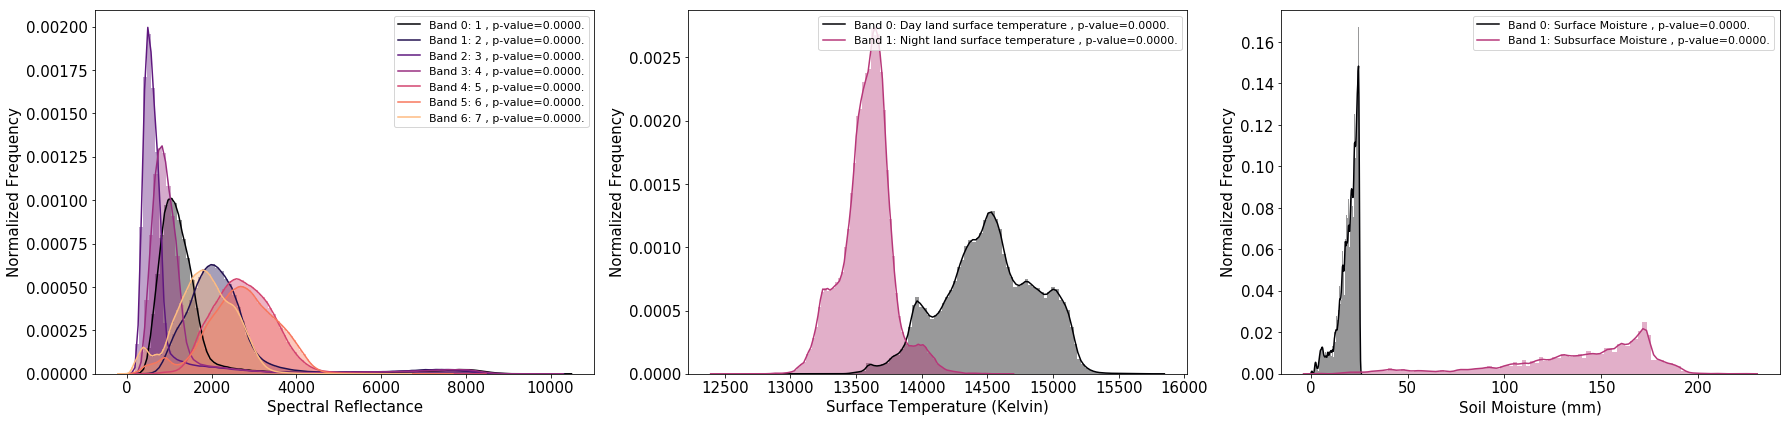

In [10]:
# 2000

cm = pylab.get_cmap('viridis')
band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
             'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature'],
             'USDA_MOISTURE': ['Surface Moisture', 'Subsurface Moisture']}
nband = [7, 2, 2]
plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP, plt_USDA_MOISTURE]
xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)', 'Soil Moisture (mm)']

f, axs = plt.subplots(1, 3, figsize=(25,6))

for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
    cm = pylab.get_cmap('magma')
    
    for band in range(nband[i]):
        color = cm(1.*band/nband[i])
        _, p = normaltest(plt_file[band])
        sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
                     kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
    axs[i].set_xlabel(xlabel[i], fontsize=MEDIUM_SIZE)
    axs[i].set_ylabel('Normalized Frequency', fontsize=MEDIUM_SIZE)
    
plt.tight_layout()
plt.savefig('Distrubution', dpi=500)
plt.show()

In [11]:
def get_stats(file_dir, nband, nsample, yield_dataframe):
    
    import random

    avg_MODIS_LAND = {band:[] for band in range(0, nband)}  # average per images (38 images per year for MODIS)
    std_MODIS_LAND = {band:[] for band in range(0, nband)}
    count_MODIS_LAND = {band:[] for band in range(0, nband)}
    
    avg_year = {band:[] for band in range(0, nband)}   # yearly average (for plotting)
    var_year = {band:[] for band in range(0, nband)}
    max_year = {band:[] for band in range(0, nband)}
    count_year = {band:[] for band in range(0, nband)}
    
    avg_total = {band:[] for band in range(0, nband)}     # Total average (for statistical analysis)
    std_total = {band:[] for band in range(0, nband)} 
    
    yield_ = []
    nband = nband
    nsample = nsample

    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values
    rand_idx = random.sample(range(0, len(fips)), nsample)
    for i, _ in enumerate(fips[rand_idx]):
        try:
            test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
            yield_ += [yield_dataframe['YIELD'][(yield_dataframe['STATE_FIPS'] == int(fips[i][1])) & (yield_dataframe['COUNTY_FIPS'] == int(fips[i][2])) \
                                          & (yield_dataframe['YEAR'] == int(fips[i][0]))].values]
            for band in range(nband):
                bands = list(np.arange(band, test.shape[2], nband)) 
                non_zero_index = test[:, :, bands].nonzero()
                count_year[band] += [len(non_zero_index[0])]
                avg_year[band] += [test[:, :, bands][non_zero_index].mean()]
                var_year[band] += [test[:, :, bands][non_zero_index].var()]
                max_year[band] += [test[:, :, bands].max()]

                #for time in range(int(test.shape[2]/nband)):
                    #non_zero_index = test[:, :, band + time*nband].nonzero()
                    #count_MODIS_LAND[band] = np.append(count_MODIS_LAND[band],len(non_zero_index[0]))
                    #avg_MODIS_LAND[band] = np.append(avg_MODIS_LAND[band], test[:, :, band + time*nband][non_zero_index].mean())
                    #std_MODIS_LAND[band] = np.append(std_MODIS_LAND[band], test[:, :, band + time*nband][non_zero_index].std())
        except:
            pass

    for band in range(nband):
        # Delete NaN (i.e. samples that do not have any corn in that year)
        nan_idx = np.argwhere(np.isnan(avg_year[band]))
        avg_year[band] = np.delete(avg_year[band], nan_idx)
        var_year[band] = np.delete(var_year[band], nan_idx)
        count_year[band] = np.delete(count_year[band], nan_idx)
        

        avg_total[band] = np.sum(avg_year[band]*np.array(count_year[band]))/ np.sum(count_year[band])
        std_total[band] = np.sqrt(np.sum(var_year[band]*np.array(count_year[band]))/ np.sum(count_year[band]))
        
    yield_ = np.delete(yield_, nan_idx)       
    return avg_year, count_year, max_year, yield_, avg_total, std_total


nsample = 2000

avg_year_LAND, count_year_LAND, max_year_LAND, yield_LAND, avg_total_LAND, std_total_LAND = \
get_stats('D://projectII_temp_data//MODIS_LAND//', 7, nsample, corn_grain)

avg_year_TEMP, count_year_TEMP, max_year_TEMP, yield_TEMP, avg_total_TEMP, std_total_TEMP =\
get_stats('D://projectII_temp_data//MODIS_TEMP//', 2, nsample, corn_grain)

avg_year_MOISTURE, count_year_MOISTURE, max_year_MOISTURE, yield_MOISTURE, avg_total_MOISTURE, std_total_MOISTURE =\
get_stats('D://projectII_temp_data//USDA_MOISTURE//', 2, nsample, corn_grain)

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice.
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encou

D:\Programs\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


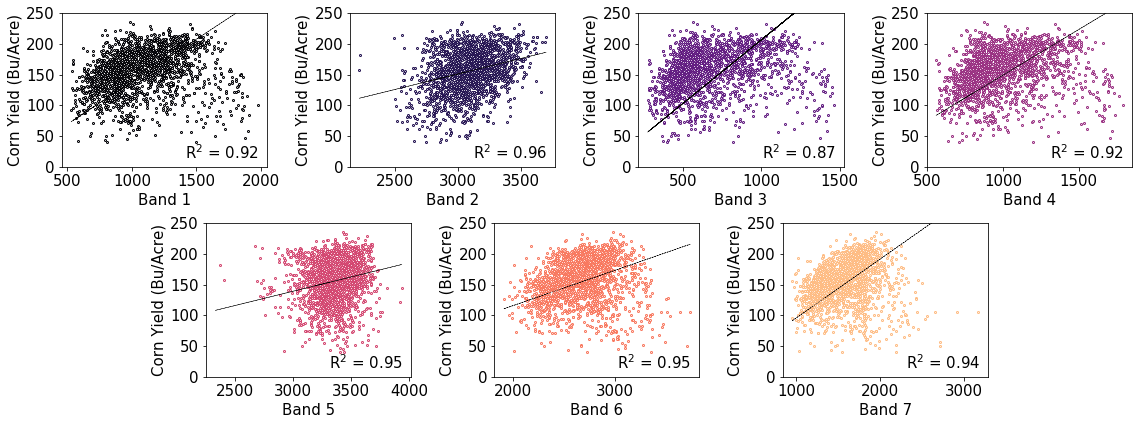

In [12]:
from matplotlib import gridspec
import statsmodels.api as sm


fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(nrows=2, ncols=16)

ax11 = fig.add_subplot(gs[0, :4])
ax21 = fig.add_subplot(gs[0, 4:8])
ax31 = fig.add_subplot(gs[0, 8:12])
ax41 = fig.add_subplot(gs[0, 12:16])
ax12 = fig.add_subplot(gs[1, 2:6])
ax22 = fig.add_subplot(gs[1, 6:10])
ax32 = fig.add_subplot(gs[1, 10:14])

axs = [ax11, ax21, ax31, ax41, ax12, ax22, ax32]
cm = pylab.get_cmap('magma')
nband = 7

for ax, band in zip(axs, avg_year_LAND):
    
    x = np.array(avg_year_LAND[band])
    y = np.array(yield_LAND)
    
    color = cm(1*band/nband)
    ax.scatter(x, y, color='white', edgecolors=color, s=4)
    ax.set_xlabel('Band ' + str(band + 1))
    ax.set_ylabel('Corn Yield (Bu/Acre)')
    
    # Generated linear fit
    results = sm.OLS(y, x).fit()
    line = results.params[0]*x
    ax.plot(x, line, '--', color='black',  linewidth=0.5)
    ax.annotate('R$^2$ = {:.2f}'.format(results.rsquared), xy=(0.6, 0.05), xycoords='axes fraction', fontsize=15)
    ax.set_ylim([0, 250])

fig.tight_layout()
plt.savefig('MODIS', dpi=500)
plt.show()

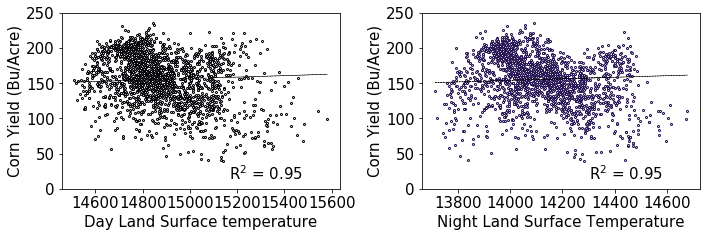

In [516]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(nrows=2, ncols=16)

ax11 = fig.add_subplot(gs[0, :8])
ax21 = fig.add_subplot(gs[0, 8:16])
xlabel = ['Day Land Surface temperature', 'Night Land Surface Temperature']
axs = [ax11, ax21]
cm = pylab.get_cmap('magma')
nband = 7

for i, (ax, band) in enumerate(zip(axs, avg_year_TEMP)):
    
    x = np.array(avg_year_TEMP[band])
    y = np.array(yield_TEMP)
    # Delete NaN
    nan_idx = np.argwhere(np.isnan(x))
    x = np.delete(x, nan_idx)
    y = np.delete(y, nan_idx)
    
    color = cm(1*band/nband)
    ax.scatter(x, y, color='white', edgecolors=color, s=4)
    ax.set_xlabel(xlabel[i])
    ax.set_ylabel('Corn Yield (Bu/Acre)')
    
    # Generated linear fit
    results = sm.OLS(y, x).fit()
    line = results.params[0]*x
    ax.plot(x, line, '--', color='black',  linewidth=0.5)
    ax.annotate('R$^2$ = {:.2f}'.format(results.rsquared), xy=(0.6, 0.05), xycoords='axes fraction', fontsize=15)
    ax.set_ylim([0, 250])

fig.tight_layout()
plt.show()

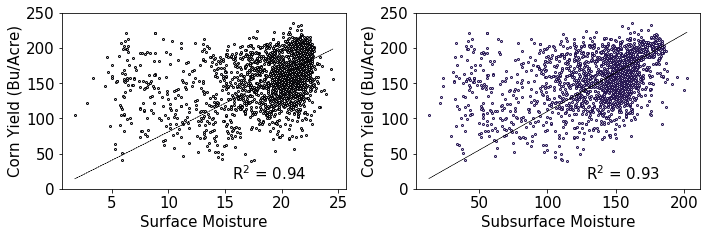

In [13]:
# 2000

cm = pylab.get_cmap('viridis')
band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
             'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature'],
             'USDA_MOISTURE': ['Surface Moisture', 'Subsurface Moisture']}
nband = [7, 2, 2]
plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP, plt_USDA_MOISTURE]
xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)', 'Soil Moisture (mm)']

f, axs = plt.subplots(1, 3, figsize=(25,6))

for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
    cm = pylab.get_cmap('magma')
    
    for band in range(nband[i]):
        color = cm(1.*band/nband[i])
        _, p = normaltest(plt_file[band])
        sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
                     kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
    axs[i].set_xlabel(xlabel[i], fontsize=MEDIUM_SIZE)
    axs[i].set_ylabel('Normalized Frequency', fontsize=MEDIUM_SIZE)
    
plt.tight_layout()
plt.savefig('MOISTURE')
plt.show()